In [1]:
import numpy as np
import deeptime.markov.msm as dm
import matplotlib.pyplot as plt
import synd.core
from mr_toolkit.reweighting import splicing
from scipy.special import rel_entr

/home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# NESS Trajectory Splicing

In order to obtain unbiased estimates of a nonequilibrium steady-state distribution, it is *not* sufficient to compute a transition matrix from equilibrium trajectories and apply recycling boundary conditions to the matrix.

Instead, unbiased estimates require incorporating the boundary conditions *into the trajectories*, and then computing a transition matrix, which will then naturally contain the appropriate boundary conditions.

Load some pre-discretized sample trajectories

In [2]:
trajectories = np.load('sample_data/coarser-sample_trajectories.npy')

Define a set of source and target states

In [3]:
state_definitions = np.load('sample_data/coarser-state_definitions.npz')

source_states = state_definitions['source']
target_states = state_definitions['target']
# target_states = np.array([400,401,402])

In [4]:
ref_ness = np.load('sample_data/coarser-reference_distributions.npz')['ness']
synd_model = synd.core.load_model('sample_data/coarser-model.synd')

In [5]:
lagtime = 10

## Standard MSM approach

Obtain a biased estimate, by applying boundary conditions to the transition matrix

In [6]:
msm = dm.MaximumLikelihoodMSM().fit_from_discrete_timeseries(trajectories, lagtime)

In [7]:
tmatrix = msm.fetch_model().transition_matrix

In [8]:
recycling_tmatrix = tmatrix.copy()

recycling_tmatrix[target_states,:] = 0.0
recycling_tmatrix[target_states, source_states] = 1.0

recycling_msm = dm.MarkovStateModel(recycling_tmatrix)

In [9]:
biased_ness = recycling_msm.stationary_distribution

## Splicing (unbiased) approach

Now, we'll instead apply the boundary conditions to the trajectories.

In [10]:
spliced_trajectories = splicing.iterative_trajectory_splicing(
    trajs=trajectories,
    sink_states = target_states,
    source_states = source_states,
    splice_msm_lag = 1,
    n_clusters = len(tmatrix),
    max_iterations=1000
)

Splicing iteration:  17%|█████████████████████████████████████▉                                                                                                                                                                                        | 171/1000 [00:06<00:30, 27.62it/s]


(Optionally, backmap the trajectories so you can visualize them in coordinate-space. The coordinate for this model is essentially an RMSD.)

In [11]:
spliced_backmapped = synd_model.backmap(spliced_trajectories)
original_backmapped = synd_model.backmap(trajectories)

Visualize the spliced trajectories

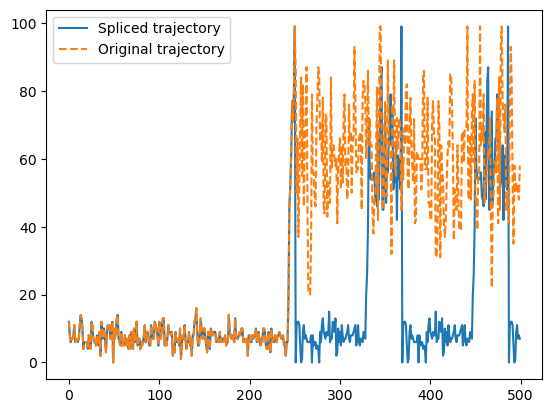

In [12]:
window = 250

target_entry_traj, target_entry_point = np.argwhere(trajectories == target_states[0])[0]

plt.plot(
    spliced_trajectories[
    # spliced_backmapped[
        target_entry_traj,
        target_entry_point-window:target_entry_point+window
    ],
    label='Spliced trajectory'
)

plt.plot(
    trajectories[
    # original_backmapped[
        target_entry_traj,
        target_entry_point-window:target_entry_point+window
    ],
    '--',
    label='Original trajectory'
)

plt.legend()

And obtain a Markov estimate from the trajectories.

We toggle on `allow_disconnected`, because splicing may affect sampling of some states near the target.

In [13]:
spliced_model = dm.MaximumLikelihoodMSM(allow_disconnected=True).fit_from_discrete_timeseries(spliced_trajectories, lagtime=lagtime)

spliced_ness = spliced_model.fetch_model().stationary_distribution

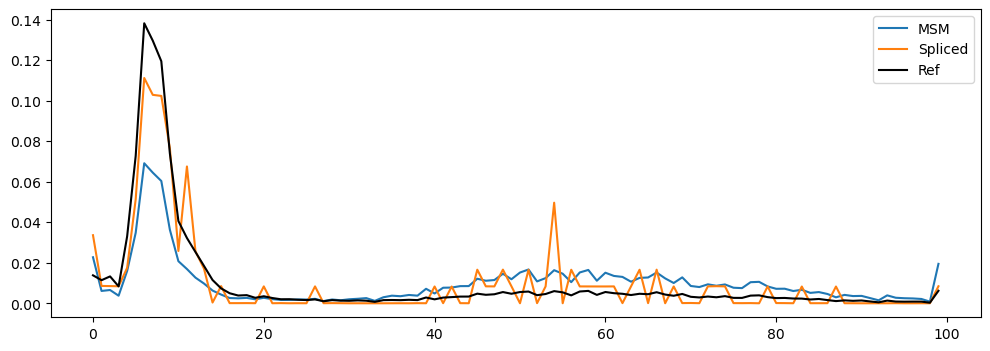

In [14]:
plt.plot(biased_ness, label='MSM')
plt.plot(spliced_ness, label='Spliced')
plt.plot(ref_ness, color='k', label='Ref')

plt.gcf().set_size_inches(12,4)
plt.legend()